# 도로 이미지 만들기
## exploration_7

## 목표
---
1. pix2pix모델 학습윌 위한 데이터셋 구축
    1. 데이터 분석
    2. 한가지 이상의 augmentation을 포함한 데이터셋 구축
2. pix2pix모델 구현
    1. U-Net generator, discriminator 모델 구현
    2. train_step의 output을 확인하고 개선
3. 학습 과정 및 테스트
    1. 10 epoch 이상의 학습을 진행
    2. 과정 로그 및 결과 시각화

## 모델 설계
---
1. 데이터셋 구축
    1. 데이터 분석
    2. augmentation을 포함한 데이터셋 구축
2. pix2pix모델 구현
    1. u-net generator 구현
    2. discriminator 모델 구현
3. 모델 학습
    1. 10 epoch 이상 학습 진행
    2. 진행과정 로그
4. 결과 확인
    1. 결과 시각화

## 1. 데이터셋 구축

In [1]:
# 라이브러리 로드
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import image, data
from tensorflow.keras import layers, Input, Model, losses, optimizers
from tensorflow.keras.preprocessing.image import random_rotation

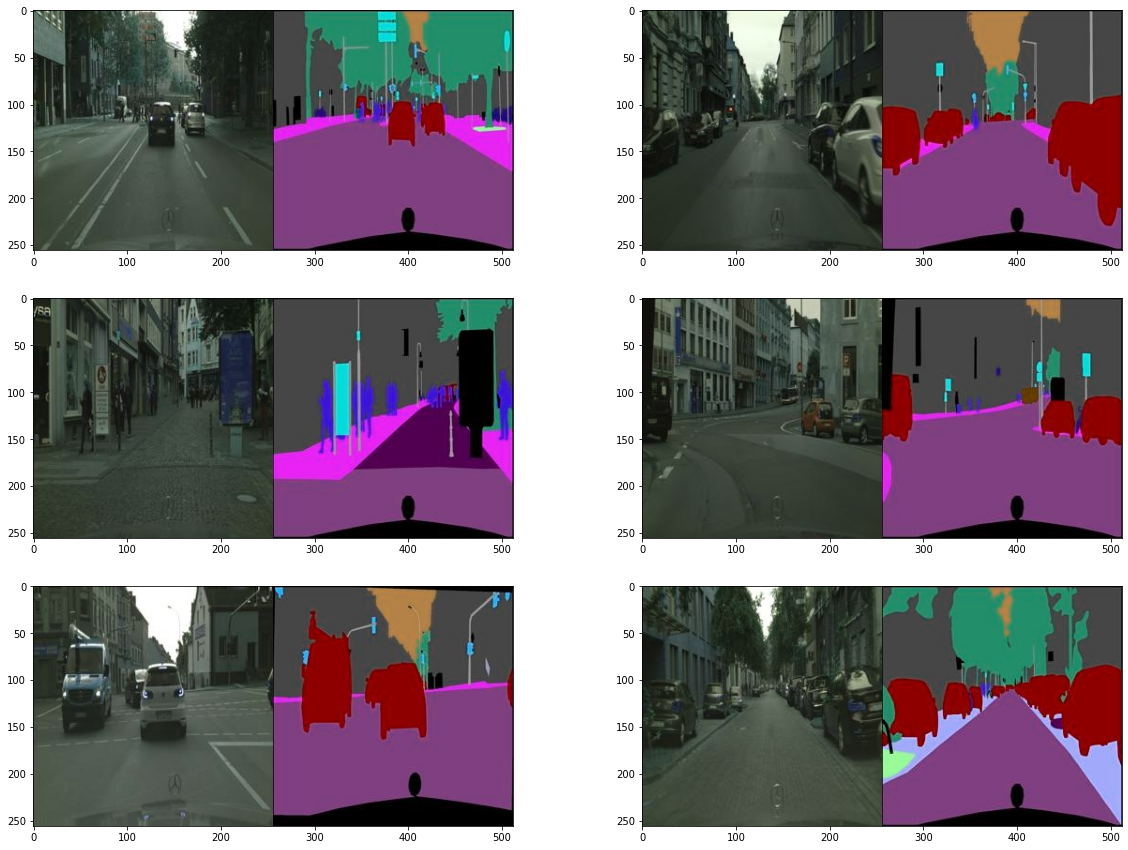

In [2]:
# 데이터 로드

data_path = 'image_data/train/'

# 데이터 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(999)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
# 첫번째 파일로 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
image_h, image_w, _ = img.shape
print(image_h, image_w)

256 512


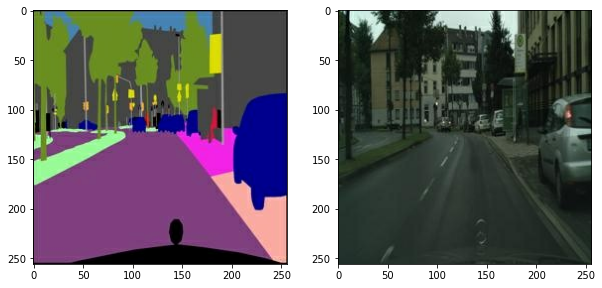

In [4]:
# 이미지 분리

def normalize(x):
    """
    이미지 정규화
    """
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    """
    정규화된 이미지 되돌리기
    """
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    """
    이미지 경로에서 파일을 읽어들여 인풋과 아웃풋으로 분리하고 정규화하여 반환
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    actual = img[:, :w, :] 
    actual = tf.cast(actual, tf.float32)
    painting = img[:, w:, :] 
    painting = tf.cast(painting, tf.float32)
    return normalize(painting), normalize(actual)

f = data_path + os.listdir(data_path)[1]
painting, actual = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(painting))
plt.subplot(1,2,2); plt.imshow(denormalize(actual))

In [5]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(painting, actual):
    """
    패딩, 자르기, 반전, 회전 augmentation방법을 랜덤으로 하여 데이터 생성 
    """
    stacked = tf.concat([painting, actual], axis=-1)
    
    # 패딩
    _pad = tf.constant([[30,30], [30,30], [0,0]])
    
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    # 이미지 자르기
    out = image.random_crop(padded, size=[256, 256, 6])
    
    # 반전
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

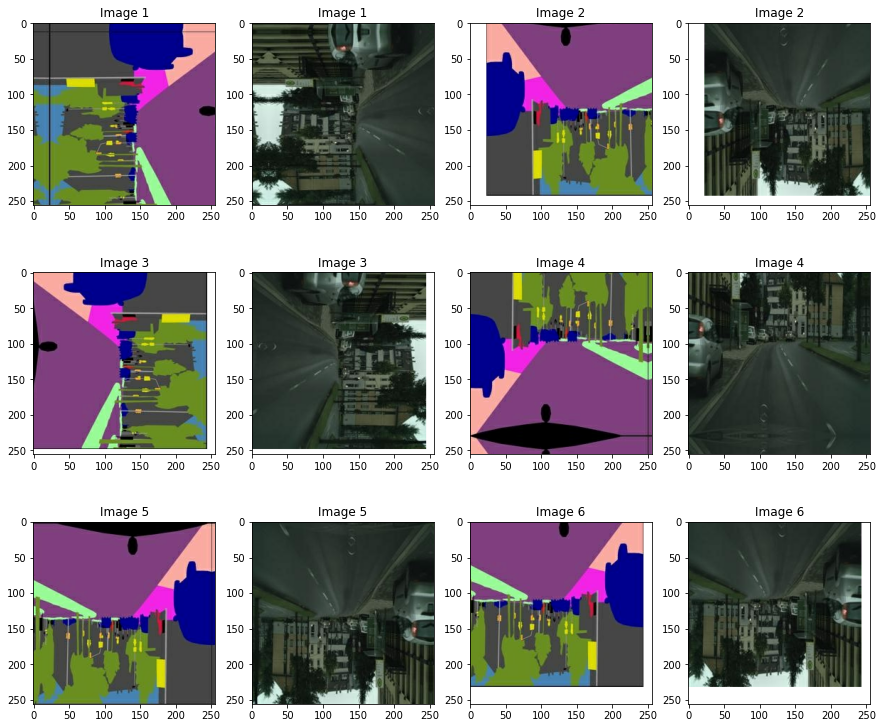

In [6]:
# augmentation 테스트
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_painting, augmented_actual = apply_augmentation(painting, actual)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_painting)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_actual)); plt.title(f"Image {img_n}")
    img_n += 1

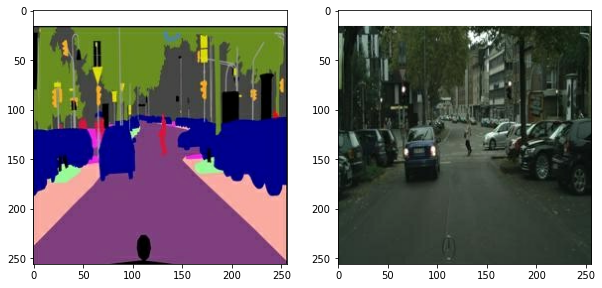

In [7]:
def get_train(img_path):
    """
    데이터를 변형시켜 반환
    """
    painting, actual = load_img(img_path)
    painting, actual = apply_augmentation(painting, actual)
    return painting, actual

# 데이터 셋을 변환하고 섞기
train_ori_images = data.Dataset.list_files(data_path + "*.jpg")

# 데이터 9배 증폭 = 총 만장
for i in range(9):
    if not 0:
        train_images = train_ori_images.map(get_train)
    else:
        add_images = train_ori_images.map(get_train)
        train_images = train_images.concatenate(add_images)

train_images = train_images.shuffle(100).batch(32)
    
# 이미지 하나를 확인
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
painting, actual = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(painting[0].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(actual[0].astype(np.uint8))

## 2. pix2pix모델 구현

In [8]:
# generator 구현


class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
# discriminator구현


class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [11]:
class Discriminator(Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64, 128, 256, 512, 1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 
        # 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
                n_filters=f,
                stride=2 if i < 3 else 1,
                custom_pad=False if i < 3 else True,
                use_bn=False if i in [0, 4] else True,
                act=True if i < 4 else False
            ))
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, x, y):
        out = None
        for i, block in enumerate(self.blocks):
            if i == 0:
                out = block([x, y])
            else:
                out = block(out)

        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

Discriminator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]            

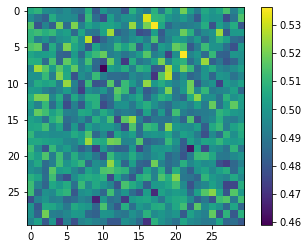

In [12]:
# (256,256,3) 크기의 입력을 넣어 (30,30) 출력이 되는지 시각화를 테스트
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 3. 모델 학습

In [13]:
# 로스 구성
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [14]:
# 옵티마이저
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [15]:
generator = UNetGenerator()
discriminator = Discriminator()

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [16]:
EPOCHS = 500

# gene_loss_list = list()
# l1_loss_list = list()
# disc_loss_list = list()

for epoch in range(1, EPOCHS + 1):
    for i, (painting, actual) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(painting, actual)
        
#         # 10회마다 저장
#         if (i + 1) % 10 == 0:
#             gene_loss_list.append(g_loss.numpy())
#             l1_loss_list.append(l1_loss.numpy())
#             disc_loss_list.append(d_loss.numpy())
                
    # epoch마다 손실을 출력합니다.        
    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1]             
Generator_loss:0.8366             
L1_loss:0.1797             
Discriminator_loss:1.4981

EPOCH[2]             
Generator_loss:1.6073             
L1_loss:0.2045             
Discriminator_loss:1.3114

EPOCH[3]             
Generator_loss:1.1204             
L1_loss:0.1914             
Discriminator_loss:1.0242

EPOCH[4]             
Generator_loss:0.9578             
L1_loss:0.2140             
Discriminator_loss:0.8463

EPOCH[5]             
Generator_loss:1.4204             
L1_loss:0.1695             
Discriminator_loss:0.6238

EPOCH[6]             
Generator_loss:0.6491             
L1_loss:0.2170             
Discriminator_loss:1.2853

EPOCH[7]             
Generator_loss:1.3792             
L1_loss:0.1693             
Discriminator_loss:0.6698

EPOCH[8]             
Generator_loss:2.3426             
L1_loss:0.1928             
Discriminator_loss:1.1755

EPOCH[9]             
Generator_loss:0.6575             
L1_loss:0.2136             
Discriminator_loss:

EPOCH[74]             
Generator_loss:1.0931             
L1_loss:0.1603             
Discriminator_loss:1.8103

EPOCH[75]             
Generator_loss:0.7253             
L1_loss:0.1864             
Discriminator_loss:1.9703

EPOCH[76]             
Generator_loss:0.4790             
L1_loss:0.1563             
Discriminator_loss:1.3850

EPOCH[77]             
Generator_loss:0.2401             
L1_loss:0.1764             
Discriminator_loss:2.2617

EPOCH[78]             
Generator_loss:1.1796             
L1_loss:0.1825             
Discriminator_loss:0.9030

EPOCH[79]             
Generator_loss:0.6120             
L1_loss:0.1982             
Discriminator_loss:0.9461

EPOCH[80]             
Generator_loss:1.1991             
L1_loss:0.1664             
Discriminator_loss:0.7207

EPOCH[81]             
Generator_loss:0.6927             
L1_loss:0.1941             
Discriminator_loss:1.1568

EPOCH[82]             
Generator_loss:0.6057             
L1_loss:0.1957             
Discrimina

EPOCH[147]             
Generator_loss:1.7495             
L1_loss:0.1764             
Discriminator_loss:0.7493

EPOCH[148]             
Generator_loss:1.2902             
L1_loss:0.1844             
Discriminator_loss:0.6833

EPOCH[149]             
Generator_loss:2.1773             
L1_loss:0.1904             
Discriminator_loss:0.5172

EPOCH[150]             
Generator_loss:0.7221             
L1_loss:0.1673             
Discriminator_loss:0.9431

EPOCH[151]             
Generator_loss:1.1012             
L1_loss:0.1663             
Discriminator_loss:1.5109

EPOCH[152]             
Generator_loss:1.3041             
L1_loss:0.1487             
Discriminator_loss:1.7374

EPOCH[153]             
Generator_loss:0.6645             
L1_loss:0.1656             
Discriminator_loss:1.7238

EPOCH[154]             
Generator_loss:2.1248             
L1_loss:0.1716             
Discriminator_loss:0.9992

EPOCH[155]             
Generator_loss:0.6736             
L1_loss:0.1820             
D

EPOCH[219]             
Generator_loss:1.2393             
L1_loss:0.1711             
Discriminator_loss:1.0218

EPOCH[220]             
Generator_loss:2.0678             
L1_loss:0.1750             
Discriminator_loss:1.0740

EPOCH[221]             
Generator_loss:0.8563             
L1_loss:0.1533             
Discriminator_loss:1.6452

EPOCH[222]             
Generator_loss:0.9192             
L1_loss:0.1631             
Discriminator_loss:0.7868

EPOCH[223]             
Generator_loss:1.3592             
L1_loss:0.1729             
Discriminator_loss:1.0965

EPOCH[224]             
Generator_loss:1.3502             
L1_loss:0.1565             
Discriminator_loss:2.0069

EPOCH[225]             
Generator_loss:1.2109             
L1_loss:0.1446             
Discriminator_loss:1.5359

EPOCH[226]             
Generator_loss:0.5422             
L1_loss:0.1488             
Discriminator_loss:1.1147

EPOCH[227]             
Generator_loss:1.2198             
L1_loss:0.1621             
D

EPOCH[291]             
Generator_loss:1.8756             
L1_loss:0.1447             
Discriminator_loss:1.9619

EPOCH[292]             
Generator_loss:0.9525             
L1_loss:0.1815             
Discriminator_loss:0.8710

EPOCH[293]             
Generator_loss:0.8059             
L1_loss:0.1669             
Discriminator_loss:0.7975

EPOCH[294]             
Generator_loss:0.9469             
L1_loss:0.1677             
Discriminator_loss:2.0589

EPOCH[295]             
Generator_loss:1.3338             
L1_loss:0.1719             
Discriminator_loss:1.0401

EPOCH[296]             
Generator_loss:0.6922             
L1_loss:0.1500             
Discriminator_loss:1.2641

EPOCH[297]             
Generator_loss:1.4974             
L1_loss:0.1573             
Discriminator_loss:1.0257

EPOCH[298]             
Generator_loss:0.4417             
L1_loss:0.1676             
Discriminator_loss:1.2514

EPOCH[299]             
Generator_loss:1.4821             
L1_loss:0.1595             
D

EPOCH[363]             
Generator_loss:0.6494             
L1_loss:0.1545             
Discriminator_loss:1.0197

EPOCH[364]             
Generator_loss:0.3988             
L1_loss:0.1556             
Discriminator_loss:1.4059

EPOCH[365]             
Generator_loss:0.9805             
L1_loss:0.1575             
Discriminator_loss:0.8449

EPOCH[366]             
Generator_loss:1.0009             
L1_loss:0.1574             
Discriminator_loss:2.3407

EPOCH[367]             
Generator_loss:0.5517             
L1_loss:0.1685             
Discriminator_loss:1.3212

EPOCH[368]             
Generator_loss:1.1180             
L1_loss:0.1555             
Discriminator_loss:2.4059

EPOCH[369]             
Generator_loss:1.1572             
L1_loss:0.1607             
Discriminator_loss:0.6143

EPOCH[370]             
Generator_loss:0.8504             
L1_loss:0.1638             
Discriminator_loss:0.8399

EPOCH[371]             
Generator_loss:0.5145             
L1_loss:0.1709             
D

EPOCH[435]             
Generator_loss:0.4684             
L1_loss:0.1669             
Discriminator_loss:1.2230

EPOCH[436]             
Generator_loss:1.1109             
L1_loss:0.1426             
Discriminator_loss:1.7550

EPOCH[437]             
Generator_loss:0.6792             
L1_loss:0.1517             
Discriminator_loss:1.1295

EPOCH[438]             
Generator_loss:1.5020             
L1_loss:0.1649             
Discriminator_loss:0.6267

EPOCH[439]             
Generator_loss:0.4718             
L1_loss:0.1494             
Discriminator_loss:1.3505

EPOCH[440]             
Generator_loss:0.6696             
L1_loss:0.1730             
Discriminator_loss:0.8483

EPOCH[441]             
Generator_loss:1.7413             
L1_loss:0.1353             
Discriminator_loss:1.0117

EPOCH[442]             
Generator_loss:1.2269             
L1_loss:0.1481             
Discriminator_loss:1.3521

EPOCH[443]             
Generator_loss:0.5812             
L1_loss:0.1690             
D

## 4. 결과확인

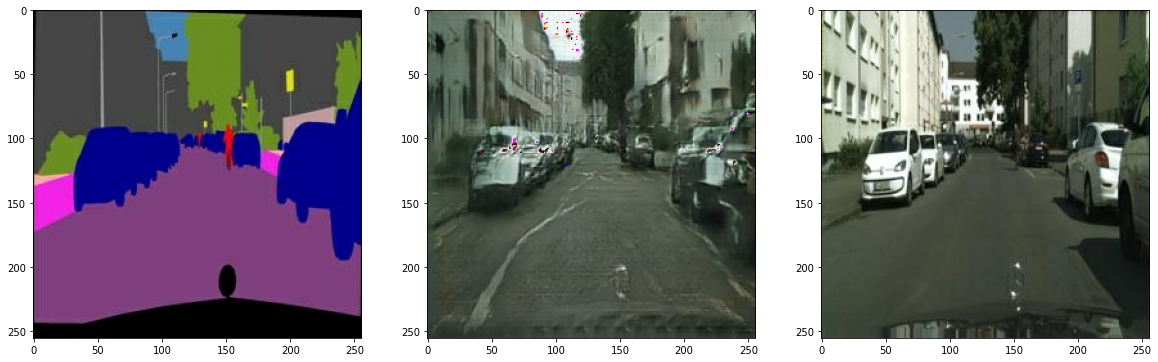

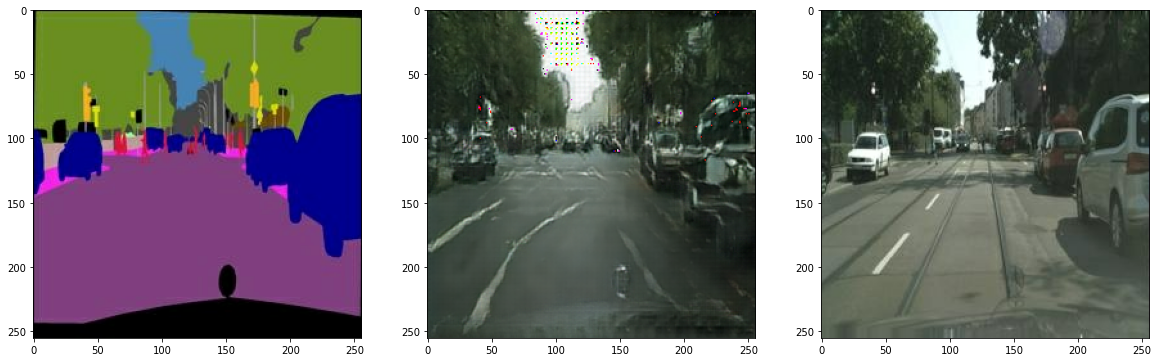

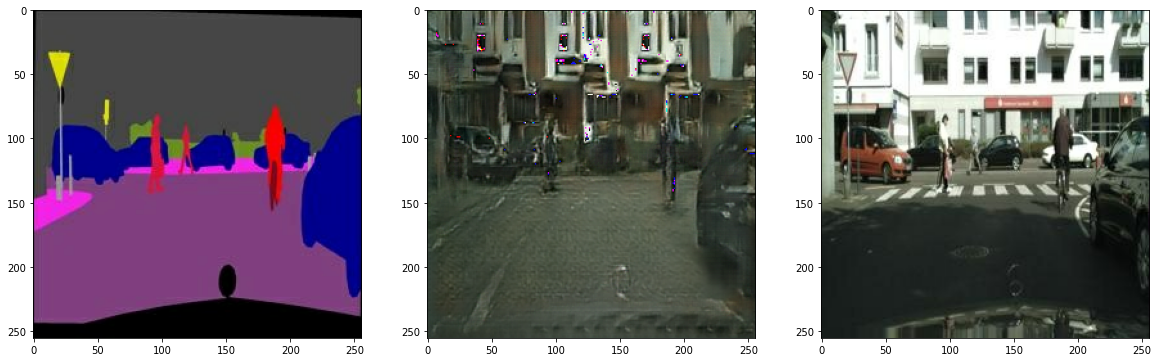

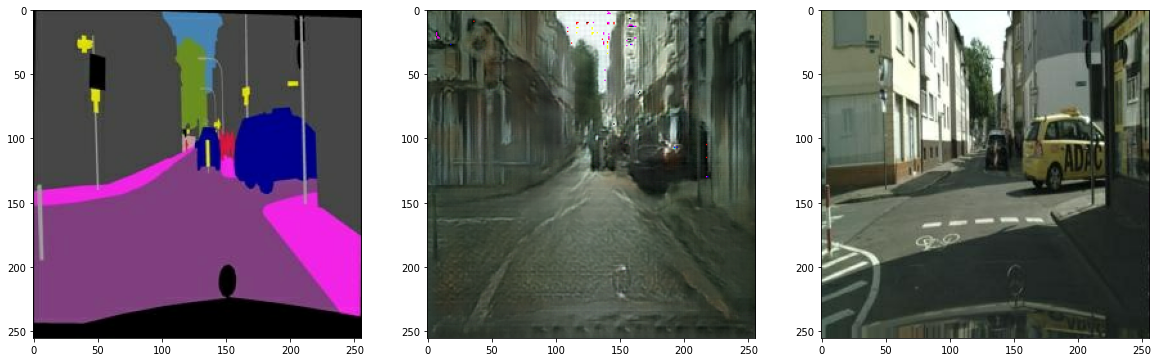

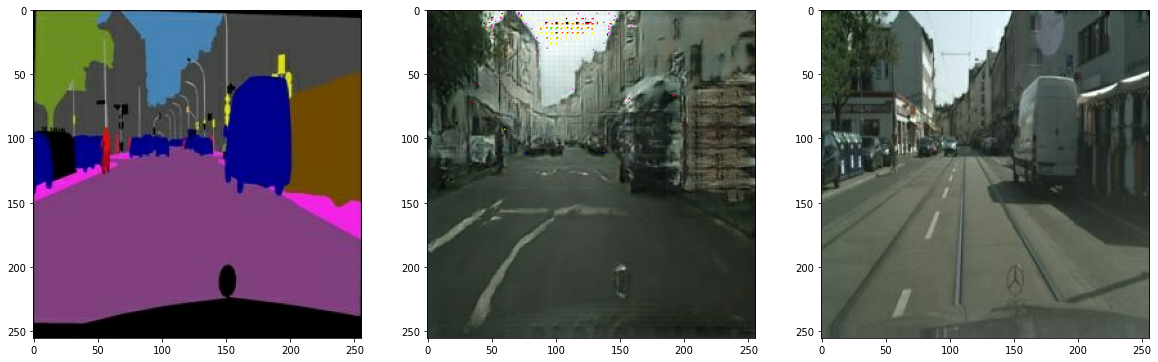

In [25]:
# 결과 확인


# validation 데이터 확인
val_folder_path = 'image_data/val/'
val_files = os.listdir(val_folder_path)
val_len = len(val_files)

for i, v in enumerate(val_files):
    f = val_folder_path + v    
    painting, actual = load_img(f)
    pred = generator(tf.expand_dims(painting, 0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(painting))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(actual))